# Summary
### Autoencoder
將load_dataset內從原本的MNIST改成讀取馬的圖片

preprocessing：
1. 由於每張圖片大小不一，將圖片resize成[height, width] = [75, 100]
2. 將圖片做normalization
3. 完成後分出train, validation, test三組

### Improved WGAN
1. 在build_model中加上gradient penalty的loss
2. 在train裏面把Optimizer和hyperparameter改成同論文上寫的， 原本WGAN是用RMSProp(lr=5e-5)， 改成Adam（lr=1e-4, beta1=0.01, beta2=0.9）, 論文上給beta1=0但我用0會錯誤所以改用0.01 

# Autoencoder

In [1]:
# Import libraries
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from time import time
import tensorflow as tf
from tensorflow.contrib import learn
from tqdm import trange
from time import time
from Autoencoder.utils import *
from sklearn.model_selection import train_test_split
from PIL import Image

/home/chen/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
class AutoEncoder(object):

  def __init__(self,
               sess,
               inputs,
               targets=None,
               b1=0.5,
               lr=1.,
               code_size=16,
               batch_size=64,
               n_epoch=1000,
               cost_function='bce',
               name='autoencoder',
               optimizer='adadelta'):
    self.sess = sess  #tensorflow session
    self.b1 = b1  #beta1 for AdadeltaOptimizer
    self.lr = lr  #learning rate
    self.n_epoch = n_epoch  #number of epoch
    self.batch_size = batch_size
    self.inputs = inputs
    self.code_size = code_size  #embedding size
    self.load_dataset()
    if targets is not None:
      self.targets = targets  #for autoencoder, targets is the same to input
      self.gen_noisy_data()
    else:
      self.targets = inputs
    self.cost_function = cost_function
    self.optimizer = optimizer
    self.log = {'train_loss': [], 'valid_loss': []}

    self.name = name

    self.build_model()

  def build_model(self):
    code_size = self.code_size
    with tf.variable_scope(self.name) as scope:
      self.enc1 = tf.layers.dense(
          inputs=self.inputs,
          units=code_size * 16,
          activation=tf.nn.relu,
          name='enc')
      self.enc2 = tf.layers.dense(
          inputs=self.enc1,
          units=code_size * 8,
          activation=tf.nn.relu,
          name='enc2')
      self.enc3 = tf.layers.dense(
          inputs=self.enc2,
          units=code_size * 4,
          activation=tf.nn.relu,
          name='enc3')
      self.code = tf.layers.dense(
          inputs=self.enc3, units=code_size, activation=tf.nn.relu, name='code')

      self.dec1 = tf.layers.dense(
          inputs=self.code,
          units=code_size * 4,
          activation=tf.nn.relu,
          name='dec')
      self.dec2 = tf.layers.dense(
          inputs=self.dec1,
          units=code_size * 8,
          activation=tf.nn.relu,
          name='dec2')
      self.dec3 = tf.layers.dense(
          inputs=self.dec2,
          units=code_size * 16,
          activation=tf.nn.relu,
          name='dec3')
      self.recon_logits = tf.layers.dense(
          inputs=self.dec3, units=100*75, name='recon_logits')
      self.jacobian_op = self.jacobian(self.code, self.inputs)
      if self.cost_function == 'mse':
        self.recon = self.recon_logits
        self.cost = tf.reduce_mean(tf.pow(self.targets - self.recon_logits, 2))
      elif self.cost_function == 'bce':
        self.recon = tf.nn.sigmoid(self.recon_logits)
        self.cost = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=self.targets, logits=self.recon_logits))

      else:
        raise NotImplementedError

  def train(self):
    if self.optimizer == 'adadelta':
      self.optim = tf.train.AdadeltaOptimizer(self.lr).minimize(self.cost)
    elif self.optimizer == 'adam':
      self.optim = tf.train.AdamOptimizer(
          self.lr, beta1=self.b1).minimize(self.cost)
    elif self.optimizer == 'rmsprop':
      self.optim = tf.train.RMSPropOptimizer(self.lr).minimize(self.cost)
    else:
      raise NotImplementedError
    init = tf.global_variables_initializer()
    self.sess.run(init)

    X = self.inputs
    t0 = time()
    if self.targets is not self.inputs:
      print('Denoising autoencoder')
      Y = self.targets
      for epoch in trange(self.n_epoch):
        t = time()
        shuffle(self.trX, self.trX_noisy)
        for batch, noisy_batch in iter_data(
            self.trX, self.trX_noisy, size=self.batch_size):
          self.optim.run(
              session=self.sess, feed_dict={X: noisy_batch,
                                            Y: batch})

        idxs = np.random.randint(
            low=0, high=len(self.vaX), size=self.batch_size)
        valid_batch = self.vaX[idxs]
        valid_noisy_batch = self.vaX_noisy[idxs]

        self.log['train_loss'].append(
            self.cost.eval(
                session=self.sess, feed_dict={X: noisy_batch,
                                              Y: batch}))
        self.log['valid_loss'].append(
            self.cost.eval(
                session=self.sess,
                feed_dict={X: valid_noisy_batch,
                           Y: valid_batch}))
      print("final loss %g, total cost time: %.2fs" % (self.cost.eval(
          session=self.sess, feed_dict={X: self.teX_noisy,
                                        Y: self.teX}), time() - t0))

    else:
      print('Autoencoder')
      for epoch in trange(self.n_epoch):
        t = time()
        shuffle(self.trX)
        for batch in iter_data(self.trX, size=self.batch_size):
          self.optim.run(session=self.sess, feed_dict={X: batch})

        idxs = np.random.randint(
            low=0, high=len(self.vaX), size=self.batch_size)
        valid_batch = self.vaX[idxs]

        self.log['train_loss'].append(
            self.cost.eval(session=self.sess, feed_dict={X: batch}))
        self.log['valid_loss'].append(
            self.cost.eval(session=self.sess, feed_dict={X: valid_batch}))
      print("final loss %g, total cost time: %.2fs" %
            (self.cost.eval(session=self.sess, feed_dict={X: self.teX}),
             time() - t0))

  def load_dataset(self):
    DIR = './gray'
    img = []
    for filename in [name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]:
        im = Image.open(os.path.join(DIR, filename))
        im = im.resize((75 , 100))
        data = np.asarray(im.getdata())
        img.append((data-min(data))/(max(data)-min(data)))
    img = np.asarray(img)
    self.trX, self.teX = train_test_split(img, test_size=0.2, random_state=0)
    self.trX, self.vaX = train_test_split(self.trX, test_size=0.2, random_state=0)

  def gen_noisy_data(self):
    # Noise scale
    noise_factor = 0.4
    trX_noisy = self.trX + noise_factor * np.random.normal(
        loc=0., scale=1.0, size=self.trX.shape)
    vaX_noisy = self.vaX + noise_factor * np.random.normal(
        loc=0., scale=1.0, size=self.vaX.shape)
    teX_noisy = self.teX + noise_factor * np.random.normal(
        loc=0., scale=1.0, size=self.teX.shape)

    # Range of our dataset is [0,1]
    self.trX_noisy = np.clip(trX_noisy, 0., 1.)
    self.vaX_noisy = np.clip(vaX_noisy, 0., 1.)
    self.teX_noisy = np.clip(teX_noisy, 0., 1.)

  def encode(self, inputs):

    return self.code.eval(session=self.sess, feed_dict={self.inputs: inputs})

  def reconstruct(self, inputs):
    return self.recon.eval(session=self.sess, feed_dict={self.inputs: inputs})

  def jacobian(self, y, x):
    # For function f: mapping from single column x to multiple values ys
    # Note: tf.gradients returns sum(dy/dx)
    # for each x in xs, so we need to compute each y seperatedly.
    jacobian_flat = tf.concat(
        [tf.gradients(y_i, x)[0] for y_i in tf.unstack(y, axis=1)], axis=0)
    return jacobian_flat

  def get_jaco_matrix(self, xbatch):
    jaco_matrix = []
    for x in xbatch:
      jaco_matrix.append(
          self.jacobian_op.eval(
              session=self.sess, feed_dict={self.inputs: x.reshape(1, -1)})
          .reshape(1, self.code_size, 100*75))
    return np.concatenate(jaco_matrix)

  def save(self, checkpoint_dir, step):
    model_name = "Autoencoder.model"
    checkpoint_dir = os.path.join(checkpoint_dir, 'Autoencoder')

    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)

    self.saver.save(
        self.sess, os.path.join(checkpoint_dir, model_name), global_step=step)

In [3]:
sess = tf.Session()
X = tf.placeholder(tf.float32, shape=[None, 100*75])
autoencoder = AutoEncoder(sess=sess, inputs=X, optimizer='adadelta', lr=1)
autoencoder.train()

  0%|          | 0/1000 [00:00<?, ?it/s]

Autoencoder


100%|██████████| 1000/1000 [00:49<00:00, 20.25it/s]

final loss 0.65412, total cost time: 49.39s


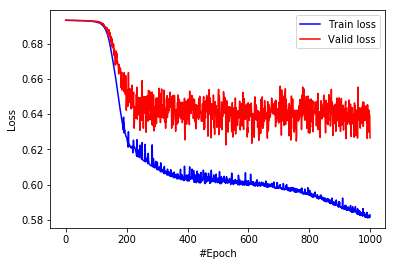

In [4]:
train_loss = autoencoder.log['train_loss']
valid_loss = autoencoder.log['valid_loss']
plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
plt.plot(range(len(valid_loss)), valid_loss, color='red', label='Valid loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

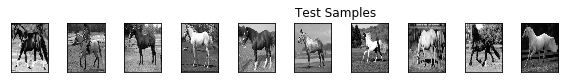

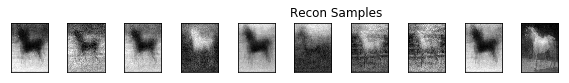

In [5]:
n = 10

orig_imgs = autoencoder.teX[:n].reshape(-1, 100, 75)
recon_imgs = autoencoder.reconstruct(
  orig_imgs.reshape(-1, 100*75)).reshape(-1, 100, 75)

plot_imgs(orig_imgs, n=n, title='Test Samples')
plot_imgs(recon_imgs, n=n, title='Recon Samples')



(1, 16, 7500)
(16,)


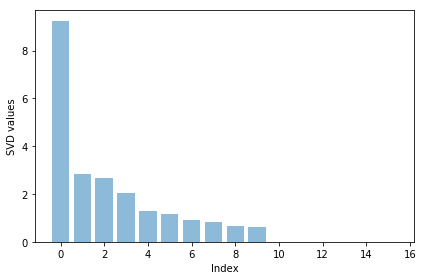

(16, 7500)


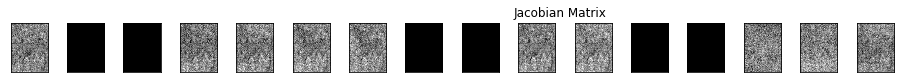

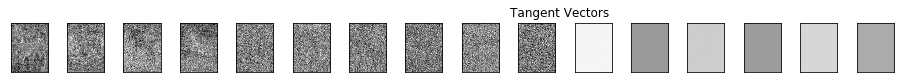

In [6]:
img = autoencoder.teX[:1]
jaco_matrix = autoencoder.get_jaco_matrix(img)
print(jaco_matrix.shape)
V = tangent_vecs(jaco_matrix[0])
print(V.shape)
plot_imgs(jaco_matrix.reshape(-1, 100, 75), n=16, title='Jacobian Matrix')
plot_imgs(V.reshape(-1, 100, 75), n=16, title='Tangent Vectors')

# Improved WGAN

In [1]:
import sys
sys.path.append('GAN')
from GAN.utils import *
from GAN.ops import *

import os
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import math
from glob import glob
from tensorflow.contrib import learn
import numpy as np
from tqdm import tqdm

/home/chen/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
class DCGAN(object):

  def __init__(self,
               sess,
               input_height=28,
               input_width=28,
               crop=True,
               batch_size=128,
               output_height=28,
               output_width=28,
               y_dim=None,
               z_dim=100,
               gf_dim=64,
               df_dim=64,
               gfc_dim=1024,
               dfc_dim=1024,
               c_dim=1,
               dataset_name='mnist',
               input_fname_pattern='*.jpg',
               checkpoint_dir='checkpoint',
               samples_dir=None,
               show_samples=False,
               learning_rate=2e-4,
               beta1=0.5,
               epoch=100):
    """
    Args:
      sess: TensorFlow session
      batch_size: The size of batch. Should be specified before training.
      y_dim: (optional) Dimension of dim for y. [None]
      z_dim: (optional) Dimension of dim for Z. [100]
      gf_dim: (optional) Dimension of gen filters in first conv layer. [64]
      df_dim: (optional) Dimension of discrim filters in first conv layer. [64]
      gfc_dim: (optional) Dimension of gen units for for fully connected layer. [1024]
      dfc_dim: (optional) Dimension of discrim units for fully connected layer. [1024]
      c_dim: (optional) Dimension of image color. For grayscale input, set to 1. [3]
        """
    self.sess = sess

    self.epoch = epoch
    self.batch_size = batch_size
    self.sample_num = 200
    self.learning_rate = learning_rate
    self.beta1 = beta1

    self.input_height = input_height
    self.input_width = input_width
    self.output_height = output_height
    self.output_width = output_width

    self.y_dim = y_dim
    self.z_dim = z_dim

    self.gf_dim = gf_dim
    self.df_dim = df_dim

    self.gfc_dim = gfc_dim
    self.dfc_dim = dfc_dim

    self.input_fname_pattern = input_fname_pattern
    self.dataset_name = dataset_name
    self.checkpoint_dir = checkpoint_dir
    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)

    self.samples_dir = samples_dir
    if not os.path.exists(samples_dir) and samples_dir is not None:
      os.makedirs(samples_dir)
    self.show_samples = show_samples

    self.trX, self.teX = self.load_mnist()
    self.ntrain = len(self.trX)
    self.c_dim = 1
    self.grayscale = (self.c_dim == 1)
    self.log = {'d_loss': [], 'g_loss': [], 'gen_samples': []}
    self.build_model()

  def build_model(self):
    image_dims = [self.input_height, self.input_width, self.c_dim]

    self.inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='real_images')
    self.sample_inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='sample_inputs')

    inputs = self.inputs
    sample_inputs = self.sample_inputs

    self.z = tf.placeholder(tf.float32, [None, self.z_dim], name='z')

    self.G = self.generator(self.z)
    self.D, self.D_logits_real = self.discriminator(inputs)

    self.D_, self.D_logits_fake = self.discriminator(self.G, reuse=True)

    self.d_loss_real = tf.reduce_mean(
        bce(self.D_logits_real, tf.ones_like(self.D)))
    self.d_loss_fake = tf.reduce_mean(
        bce(self.D_logits_fake, tf.zeros_like(self.D_)))
    self.g_loss = tf.reduce_mean(bce(self.D_logits_fake, tf.ones_like(self.D_)))

    self.d_loss = self.d_loss_real + self.d_loss_fake

    t_vars = tf.trainable_variables()
    # get variables for generator and discriminator,
    # since they are trained separately.
    self.d_vars = [var for var in t_vars if 'd_' in var.name]
    self.g_vars = [var for var in t_vars if 'g_' in var.name]

    self.saver = tf.train.Saver()

  def train(self):
    #get the optimization ops
    d_optim = tf.train.AdamOptimizer(self.learning_rate, beta1=self.beta1) \
              .minimize(self.d_loss, var_list=self.d_vars)
    g_optim = tf.train.AdamOptimizer(self.learning_rate, beta1=self.beta1) \
              .minimize(self.g_loss, var_list=self.g_vars)
    init = tf.global_variables_initializer()
    self.sess.run(init)

    #generate random noise
    sample_z = np.random.uniform(-1, 1, size=(self.sample_num, self.z_dim))
    sample_idxs = np.random.randint(
        low=0, high=len(self.trX), size=self.sample_num)
    sample_inputs = self.trX[sample_idxs]

    counter = 1
    start_time = time.time()
    print('start training')
    for epoch in range(self.epoch):
      shuffle(self.trX)
      for batch_images in iter_data(self.trX, size=self.batch_size):
        batch_z = np.random.uniform(-1, 1, [self.batch_size,
                                            self.z_dim]).astype(np.float32)
        if counter % 2 == 0:
          # Update D network
          self.sess.run(
              d_optim, feed_dict={
                  self.inputs: batch_images,
                  self.z: batch_z,
              })
        else:
          # Update G network
          self.sess.run(
              g_optim, feed_dict={
                  self.z: batch_z,
              })
        counter += 1

      # calculate the loss to monitor the training process
      errD_fake = self.d_loss_fake.eval(
          session=self.sess, feed_dict={self.z: batch_z})
      errD_real = self.d_loss_real.eval(
          session=self.sess, feed_dict={self.inputs: batch_images})
      errG = self.g_loss.eval(session=self.sess, feed_dict={self.z: batch_z})
      self.log['d_loss'].append(errD_fake + errD_real)
      self.log['g_loss'].append(errG)
      print("Epoch: [%2d] time: %.2fs, d_loss: %.4f, g_loss: %.4f" \
        % (epoch,time.time() - start_time, errD_fake+errD_real, errG))

      # save the generated samples
      if (epoch + 1) % 1 == 0:
        samples = self.sess.run(
            self.G, feed_dict={
                self.z: sample_z,
            })
        img = grayscale_grid_vis(
            samples,
            nhw=(10, 20),
            save_path=self.samples_dir + '/%d.jpg' % epoch)
        self.log['gen_samples'].append(img)
        if (epoch + 1) % 10 == 0:
          if self.show_samples:
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()

      if (epoch + 1) % 10 == 0:
        self.save(self.checkpoint_dir, counter)

  def discriminator(self, image, y=None, reuse=False):
    with tf.variable_scope("discriminator") as scope:
      if reuse:
        scope.reuse_variables()

      x = image

      h0 = lrelu(conv2d(x, self.c_dim, name='d_h0_conv'))
      h1 = lrelu(bn(conv2d(h0, self.df_dim, name='d_h1_conv')))
      h1 = flatten(h1)
      h2 = lrelu(bn(linear(h1, self.dfc_dim, 'd_h2_lin')))
      h3 = linear(h2, 1, 'd_h3_lin')

      return tf.nn.sigmoid(h3), h3

  def generator(self, z, y=None):
    with tf.variable_scope("generator") as scope:
      s_h, s_w = self.output_height, self.output_width
      s_h2, s_h4 = int(s_h / 2), int(s_h / 4)
      s_w2, s_w4 = int(s_w / 2), int(s_w / 4)

      h0 = tf.nn.relu(bn(linear(z, self.gfc_dim, 'g_h0_lin')))

      h1 = tf.nn.relu(bn(linear(h0, self.gf_dim * 2 * s_h4 * s_w4, 'g_h1_lin')))
      h1 = tf.reshape(h1, [-1, s_h4, s_w4, self.gf_dim * 2])

      h2 = tf.nn.relu(bn(deconv2d(h1, nf=self.gf_dim * 2, name='g_h2')))
      h2 = tf.reshape(h2, [-1, s_h2, s_w2, self.gf_dim * 2])
      return tf.nn.sigmoid(deconv2d(h2, nf=self.c_dim, name='g_h3'))

  def load_mnist(self):
    mnist = learn.datasets.load_dataset("mnist")
    train_data = mnist.train.images.reshape(-1, 28, 28, 1)  # Returns np.array
    test_data = mnist.test.images.reshape(-1, 28, 28, 1)  # Returns np.array
    return train_data, test_data

  @property
  def model_dir(self):
    return "%s_%s" % (self.dataset_name, self.batch_size)

  def save(self, checkpoint_dir, step):
    model_name = "DCGAN.model"
    checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)

    self.saver.save(
        self.sess, os.path.join(checkpoint_dir, model_name), global_step=step)

  def load(self, checkpoint_dir):
    import re
    print(" [*] Reading checkpoints...")
    checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
      ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
      self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
      counter = int(next(re.finditer("(\d+)(?!.*\d)", ckpt_name)).group(0))
      print(" [*] Success to read {}".format(ckpt_name))
      return True, counter
    else:
      print(" [*] Failed to find a checkpoint")
      return False, 0

In [3]:
#Inherit from DCGAN class
class WGAN(DCGAN):

  def build_model(self):

    # Training critic 5 iterations per generator iteration
    self.n_critic = 5

    image_dims = [self.input_height, self.input_width, self.c_dim]

    self.inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='real_images')
    self.sample_inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='sample_inputs')

    inputs = self.inputs
    sample_inputs = self.sample_inputs

    self.z = tf.placeholder(tf.float32, [None, self.z_dim], name='z')
    
    self.G = self.generator(self.z)
    self.D, self.D_logits_real = self.discriminator(inputs)

    self.D_, self.D_logits_fake = self.discriminator(self.G, reuse=True)
    
    Lambda = 10
    epsilon = tf.random_uniform([], 0.0, 1.0)
    x_hat = (epsilon * inputs) + (1 - epsilon) * self.G
    _ , x_hat_d = self.discriminator(x_hat, reuse=True)
    x_hat_grad = tf.gradients(x_hat_d, x_hat)[0]
    dis = tf.sqrt(tf.reduce_sum(tf.square(x_hat_grad), axis=1))
    loss_ex = Lambda * tf.reduce_mean(tf.square(dis - 1.0))
    
    self.d_loss_real = tf.reduce_mean(self.D_logits_real)
    self.d_loss_fake = tf.reduce_mean(self.D_logits_fake)
    self.g_loss = -tf.reduce_mean(self.D_logits_fake)
    self.d_loss = self.d_loss_fake - self.d_loss_real + loss_ex

    t_vars = tf.trainable_variables()

    self.d_vars = [var for var in t_vars if 'd_' in var.name]
    self.g_vars = [var for var in t_vars if 'g_' in var.name]
    self.saver = tf.train.Saver()

  def train(self):
    d_optim = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.01, beta2 = 0.9) \
              .minimize(self.d_loss, var_list=self.d_vars)
    g_optim = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.01, beta2 = 0.9) \
              .minimize(self.g_loss, var_list=self.g_vars)

    init = tf.global_variables_initializer()
    self.sess.run(init)

    sample_z = np.random.uniform(-1, 1, size=(self.sample_num, self.z_dim))
    sample_idxs = np.random.randint(
        low=0, high=len(self.trX), size=self.sample_num)
    sample_inputs = self.trX[sample_idxs]

    counter = 1
    self.n_critic += 1
    start_time = time.time()
    for epoch in range(self.epoch):
      shuffle(self.trX)
      for batch_images in iter_data(self.trX, size=self.batch_size):
        batch_z = np.random.uniform(-1, 1, [self.batch_size,
                                            self.z_dim]).astype(np.float32)
        if counter % self.n_critic:
          # Update D network
          self.sess.run(
              d_optim, feed_dict={
                  self.inputs: batch_images,
                  self.z: batch_z,
              })
        else:
          # Update G network
          self.sess.run(
              g_optim, feed_dict={
                  self.z: batch_z,
              })
        counter += 1

      errD_fake = self.d_loss_fake.eval(
          session=self.sess, feed_dict={self.z: batch_z})
      errD_real = self.d_loss_real.eval(
          session=self.sess, feed_dict={self.inputs: batch_images})
      errG = self.g_loss.eval(session=self.sess, feed_dict={self.z: batch_z})
      self.log['d_loss'].append(errD_fake + errD_real)
      self.log['g_loss'].append(errG)
      print("Epoch: [%2d] time: %.2fs, d_loss: %.4f, g_loss: %.4f" \
        % (epoch,time.time() - start_time, errD_fake+errD_real, errG))

      if (epoch + 1) % 1 == 0:
        samples = self.sess.run(
            self.G, feed_dict={
                self.z: sample_z,
            })
        img = grayscale_grid_vis(
            samples,
            nhw=(10, 20),
            save_path=self.samples_dir + '/%d.jpg' % epoch)
        self.log['gen_samples'].append(img)
        if (epoch + 1) % 10 == 0:
          if self.show_samples:
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()

      if (epoch + 1) % 10 == 0:
        self.save(self.checkpoint_dir, counter)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


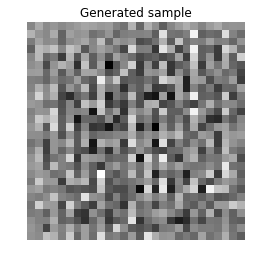

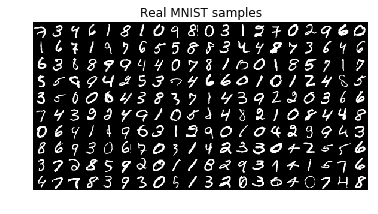

Epoch: [ 0] time: 23.79s, d_loss: -2.6443, g_loss: 1.8808
Epoch: [ 1] time: 46.59s, d_loss: -3.3859, g_loss: 3.4321
Epoch: [ 2] time: 69.55s, d_loss: -3.6986, g_loss: 4.5547
Epoch: [ 3] time: 92.57s, d_loss: -5.9842, g_loss: 7.2373
Epoch: [ 4] time: 115.38s, d_loss: -6.8002, g_loss: 8.4203
Epoch: [ 5] time: 138.15s, d_loss: -3.2794, g_loss: 6.7342
Epoch: [ 6] time: 160.91s, d_loss: 0.5052, g_loss: 6.1453
Epoch: [ 7] time: 183.70s, d_loss: 9.2999, g_loss: 2.4287
Epoch: [ 8] time: 206.52s, d_loss: 13.3556, g_loss: -0.1597
Epoch: [ 9] time: 229.31s, d_loss: 15.4038, g_loss: -0.0288


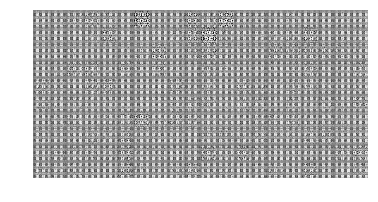

Epoch: [10] time: 252.70s, d_loss: 15.5167, g_loss: 0.2711
Epoch: [11] time: 276.16s, d_loss: 14.8715, g_loss: -0.1958
Epoch: [12] time: 298.98s, d_loss: 16.0989, g_loss: 0.6625
Epoch: [13] time: 321.74s, d_loss: 16.1855, g_loss: 0.9589
Epoch: [14] time: 344.51s, d_loss: 13.3396, g_loss: 1.1142
Epoch: [15] time: 367.30s, d_loss: 5.5179, g_loss: 2.2226
Epoch: [16] time: 390.09s, d_loss: 3.1689, g_loss: 3.0939
Epoch: [17] time: 413.15s, d_loss: 3.2043, g_loss: 1.7345
Epoch: [18] time: 435.94s, d_loss: -0.6272, g_loss: 4.4406
Epoch: [19] time: 458.73s, d_loss: -1.5230, g_loss: 4.7436


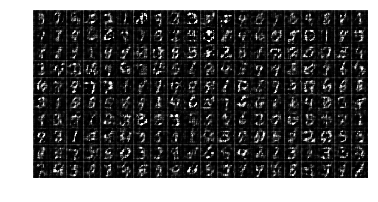

Epoch: [20] time: 482.08s, d_loss: -0.0420, g_loss: 2.7406
Epoch: [21] time: 504.85s, d_loss: -3.6986, g_loss: 5.8686
Epoch: [22] time: 527.66s, d_loss: -4.8447, g_loss: 6.4522
Epoch: [23] time: 550.45s, d_loss: -2.5913, g_loss: 3.4467
Epoch: [24] time: 573.26s, d_loss: -6.8302, g_loss: 6.9309
Epoch: [25] time: 596.03s, d_loss: -5.9983, g_loss: 6.2475
Epoch: [26] time: 618.83s, d_loss: -3.7142, g_loss: 3.6379
Epoch: [27] time: 641.63s, d_loss: -5.6882, g_loss: 6.1519
Epoch: [28] time: 664.44s, d_loss: -5.7805, g_loss: 6.0852
Epoch: [29] time: 687.22s, d_loss: -2.9417, g_loss: 2.8371


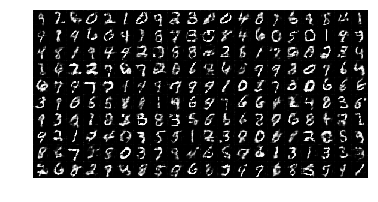

Epoch: [30] time: 710.83s, d_loss: -5.5615, g_loss: 5.8577
Epoch: [31] time: 733.92s, d_loss: -5.1653, g_loss: 5.9183
Epoch: [32] time: 756.77s, d_loss: -4.4857, g_loss: 3.4559
Epoch: [33] time: 779.61s, d_loss: -4.5447, g_loss: 5.1890
Epoch: [34] time: 802.43s, d_loss: -3.2117, g_loss: 4.3397
Epoch: [35] time: 825.27s, d_loss: -2.4094, g_loss: 2.1327
Epoch: [36] time: 848.12s, d_loss: -3.6608, g_loss: 4.8322
Epoch: [37] time: 870.96s, d_loss: -3.0449, g_loss: 4.4660
Epoch: [38] time: 893.86s, d_loss: -1.5980, g_loss: 1.4433
Epoch: [39] time: 916.70s, d_loss: -2.4706, g_loss: 3.6868


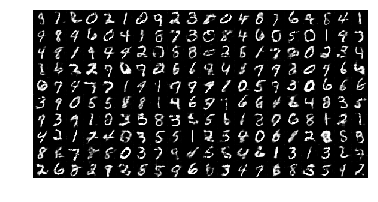

Epoch: [40] time: 940.07s, d_loss: -2.8509, g_loss: 3.8926
Epoch: [41] time: 962.90s, d_loss: 0.9120, g_loss: 0.6190
Epoch: [42] time: 985.75s, d_loss: -0.9439, g_loss: 2.9628
Epoch: [43] time: 1008.61s, d_loss: -0.6928, g_loss: 2.9937
Epoch: [44] time: 1031.45s, d_loss: 2.0716, g_loss: -0.0203
Epoch: [45] time: 1054.28s, d_loss: 0.2266, g_loss: 2.1629
Epoch: [46] time: 1077.13s, d_loss: 0.7413, g_loss: 1.8077
Epoch: [47] time: 1099.96s, d_loss: 2.9693, g_loss: -0.9679
Epoch: [48] time: 1122.80s, d_loss: 1.3487, g_loss: 1.5995
Epoch: [49] time: 1145.63s, d_loss: 2.1357, g_loss: 0.9956


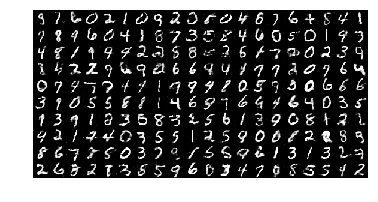

Epoch: [50] time: 1168.96s, d_loss: 5.1421, g_loss: -1.8092
Epoch: [51] time: 1191.82s, d_loss: 3.1905, g_loss: 0.8205
Epoch: [52] time: 1214.67s, d_loss: 3.5131, g_loss: 0.7767
Epoch: [53] time: 1237.51s, d_loss: 5.5776, g_loss: -2.0831
Epoch: [54] time: 1260.35s, d_loss: 5.8163, g_loss: -0.7811
Epoch: [55] time: 1283.19s, d_loss: 5.8342, g_loss: -0.6631
Epoch: [56] time: 1306.01s, d_loss: 8.4941, g_loss: -3.4171
Epoch: [57] time: 1328.84s, d_loss: 6.5359, g_loss: -1.6172
Epoch: [58] time: 1351.70s, d_loss: 6.8082, g_loss: -1.2076
Epoch: [59] time: 1374.56s, d_loss: 9.7642, g_loss: -4.2141


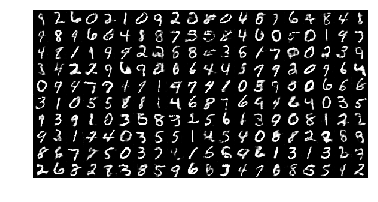

Epoch: [60] time: 1397.90s, d_loss: 8.7240, g_loss: -2.3515
Epoch: [61] time: 1420.73s, d_loss: 9.1697, g_loss: -2.6691
Epoch: [62] time: 1443.56s, d_loss: 10.5791, g_loss: -4.6789
Epoch: [63] time: 1466.40s, d_loss: 9.0954, g_loss: -2.8994
Epoch: [64] time: 1489.26s, d_loss: 10.3812, g_loss: -3.1274
Epoch: [65] time: 1512.09s, d_loss: 12.1580, g_loss: -5.6130
Epoch: [66] time: 1534.92s, d_loss: 10.7484, g_loss: -3.3956
Epoch: [67] time: 1557.76s, d_loss: 12.0456, g_loss: -3.7849
Epoch: [68] time: 1580.62s, d_loss: 14.2581, g_loss: -6.5784
Epoch: [69] time: 1603.46s, d_loss: 12.1530, g_loss: -3.8129


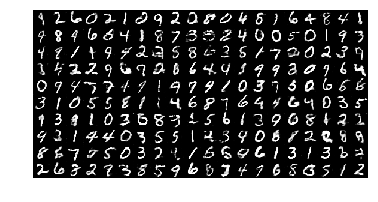

Epoch: [70] time: 1626.84s, d_loss: 13.1970, g_loss: -4.7269
Epoch: [71] time: 1649.68s, d_loss: 15.1222, g_loss: -6.9442
Epoch: [72] time: 1672.51s, d_loss: 14.9905, g_loss: -5.2453
Epoch: [73] time: 1695.34s, d_loss: 15.0852, g_loss: -5.7514
Epoch: [74] time: 1718.21s, d_loss: 16.5251, g_loss: -7.3762
Epoch: [75] time: 1741.05s, d_loss: 16.5577, g_loss: -6.0974
Epoch: [76] time: 1763.93s, d_loss: 16.4774, g_loss: -6.2623
Epoch: [77] time: 1786.76s, d_loss: 17.7945, g_loss: -8.3665
Epoch: [78] time: 1809.60s, d_loss: 17.0623, g_loss: -6.7483
Epoch: [79] time: 1832.42s, d_loss: 17.9406, g_loss: -7.2010


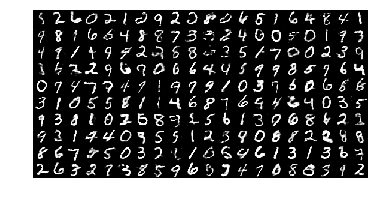

Epoch: [80] time: 1855.83s, d_loss: 19.6297, g_loss: -9.1645
Epoch: [81] time: 1878.68s, d_loss: 18.7689, g_loss: -7.1920
Epoch: [82] time: 1901.52s, d_loss: 20.1750, g_loss: -8.1783
Epoch: [83] time: 1924.34s, d_loss: 21.2028, g_loss: -10.0717
Epoch: [84] time: 1947.20s, d_loss: 20.5062, g_loss: -8.0672
Epoch: [85] time: 1970.01s, d_loss: 21.3948, g_loss: -8.9599
Epoch: [86] time: 1992.84s, d_loss: 22.9638, g_loss: -10.9130
Epoch: [87] time: 2015.66s, d_loss: 22.9656, g_loss: -9.5883
Epoch: [88] time: 2038.48s, d_loss: 22.5128, g_loss: -9.1775
Epoch: [89] time: 2061.34s, d_loss: 24.5679, g_loss: -11.9467


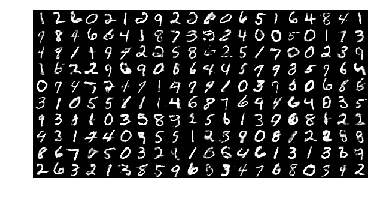

Epoch: [90] time: 2084.73s, d_loss: 23.4204, g_loss: -10.0042
Epoch: [91] time: 2107.53s, d_loss: 24.3613, g_loss: -10.1333
Epoch: [92] time: 2130.36s, d_loss: 25.5311, g_loss: -12.2132
Epoch: [93] time: 2153.19s, d_loss: 25.2608, g_loss: -10.9144
Epoch: [94] time: 2176.04s, d_loss: 24.6754, g_loss: -10.5647
Epoch: [95] time: 2198.85s, d_loss: 27.6598, g_loss: -13.5510
Epoch: [96] time: 2221.67s, d_loss: 26.1309, g_loss: -11.3547
Epoch: [97] time: 2244.51s, d_loss: 26.6225, g_loss: -11.5914
Epoch: [98] time: 2267.35s, d_loss: 28.4286, g_loss: -13.7279
Epoch: [99] time: 2290.19s, d_loss: 27.8086, g_loss: -11.9608


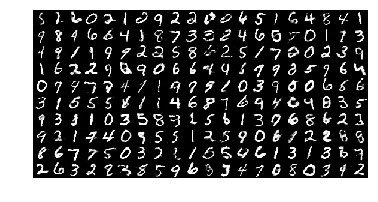

In [4]:
# Specifiy model checkpoint directory & samples directory
checkpoint_dir = 'checkpoint'
samples_dir = 'samples'

sess = tf.Session()
model = WGAN(
    sess,
    input_width=28,
    input_height=28,
    output_width=28,
    output_height=28,
    batch_size=100,
    input_fname_pattern='*.jpg',
    checkpoint_dir=checkpoint_dir,
    samples_dir=samples_dir,
    show_samples=True,
    epoch=100)

# show_all_variables()
init = tf.global_variables_initializer()
sess.run(init)
sample_z = np.random.uniform(-1, 1, size=(200, 100))
samples = model.G.eval(session=model.sess, feed_dict={model.z: sample_z})
plt.imshow(samples[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title('Generated sample')
plt.show()

samples = model.trX[:200]
img = grayscale_grid_vis(samples, nhw=(10, 20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Real MNIST samples')
plt.show()


model.train()

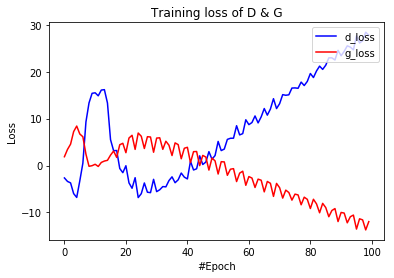

In [5]:
d_loss = model.log['d_loss']
g_loss = model.log['g_loss']
plt.plot(range(len(d_loss)), d_loss, color='blue', label='d_loss')
plt.plot(range(len(g_loss)), g_loss, color='red', label='g_loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.title('Training loss of D & G')
plt.show()

In [6]:
imgs = np.array(model.log['gen_samples'])
make_gif(imgs * 255., 'GAN/wgan.gif', true_image=True, duration=2)

from IPython.display import Image
Image(url='GAN/wgan.gif')


[MoviePy] Building file GAN/wgan.gif with imageio


 99%|█████████▉| 100/101 [00:02<00:00, 49.50it/s]


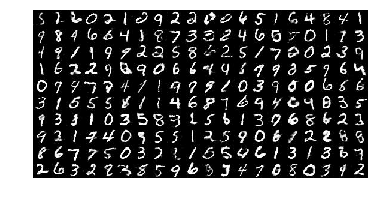

In [3]:
from scipy.misc import imread
import matplotlib.pyplot as plt
img = imread('./samples/100.jpg')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()